Copyright (c) OpenMMLab. All rights reserved.

Copyright (c) Meta Platforms, Inc. and affiliates.

Modified from https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.

In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from mmselfsup.models import build_algorithm

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install openmim
    !pip install -U openmim
    !mim install 'mmengine==0.1.0' 'mmcv>=2.0.0rc1'

    !git clone https://github.com/open-mmlab/mmselfsup.git
    %cd mmselfsup/
    !git checkout dev-1.x
    !pip install -e .

    sys.path.append('./mmselfsup')
    %cd demo
else:
    sys.path.append('..')

### Define utils

In [20]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    image = torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int()
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def show_images(x, im_masked, y, im_paste):
    # make the plt figure larger
    # plt.rcParams['figure.figsize'] = [24, 6]
    plt.rcParams['figure.figsize'] = [12, 3]

    plt.subplot(1, 4, 1)
    show_image(x, "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked, "masked")

    plt.subplot(1, 4, 3)
    show_image(y, "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste, "reconstruction + visible")

    plt.show()


def post_process(x, y, mask):
    x = torch.einsum('nchw->nhwc', x.cpu())
    # masked image
    im_masked = x * (1 - mask)
    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    return x[0], im_masked[0], y[0], im_paste[0]

### Load an image

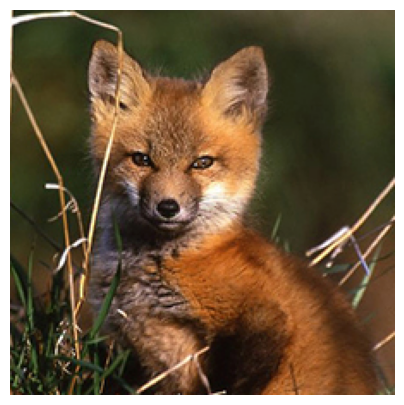

In [21]:
# load an image
img_url = 'https://download.openmmlab.com/mmselfsup/mae/fox.jpg'
img_pil = Image.open(requests.get(img_url, stream=True).raw)
img = img_pil.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [28]:
%%writefile ../configs/selfsup/mae/mae_visualization.py
model = dict(
    type='MAE',
    data_preprocessor=dict(
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True),
    backbone=dict(type='MAEViT', arch='l', patch_size=16, mask_ratio=0.75),
    neck=dict(
        type='MAEPretrainDecoder',
        patch_size=16,
        in_chans=3,
        embed_dim=1024,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.,
    ),
    head=dict(
        type='MAEPretrainHead',
        norm_pix=True,
        patch_size=16,
        loss=dict(type='MAEReconstructionLoss')),
    init_cfg=[
        dict(type='Xavier', distribution='uniform', layer='Linear'),
        dict(type='Constant', layer='LayerNorm', val=1.0, bias=0.0)
    ])

file_client_args = dict(backend='disk')

# dataset summary
test_dataloader = dict(
    dataset=dict(
        pipeline=[
            dict(type='LoadImageFromFile', file_client_args=file_client_args),
            dict(type='Resize', scale=(224, 224)),
            dict(type='PackSelfSupInputs', meta_keys=['img_path'])
    ]))

Overwriting ../configs/selfsup/mae/mae_visualization.py


In [5]:
# This is an MAE model trained with pixels as targets for visualization (ViT-large, training mask ratio=0.75)

# download checkpoint if not exist
# This ckpt is converted from https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
# !wget -nc https://download.openmmlab.com/mmselfsup/mae/mae_visualize_vit_large.pth

In [23]:
from mmselfsup.apis import init_model
ckpt_path = "mae_visualize_vit_large.pth"
model = init_model('../configs/selfsup/mae/mae_visualization.py', ckpt_path, device='cpu')
print('Model loaded.')

local loads checkpoint from path: mae_visualize_vit_large.pth
Model loaded.


### Run MAE on the image

In [25]:
!wget -nc 'https://download.openmmlab.com/mmselfsup/mae/fox.jpg'

3241.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2022-09-02 17:04:54--  https://download.openmmlab.com/mmselfsup/mae/fox.jpg
正在解析主机 download.openmmlab.com (download.openmmlab.com)... 101.133.111.186
正在连接 download.openmmlab.com (download.openmmlab.com)|101.133.111.186|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 60133 (59K) [image/jpeg]
正在保存至: “fox.jpg”

fox.jpg             100%[===================>]  58.72K  --.-KB/s    用时 0.06s   

2022-09-02 17:04:54 (949 KB/s) - 已保存 “fox.jpg” [60133/60133])



In [ ]:
# make random mask reproducible (comment out to make it change)
from mmselfsup.utils import register_all_modules
register_all_modules()
torch.manual_seed(2)
print('MAE with pixel reconstruction:')

from mmselfsup.apis import inference_model

img = 'fox.jpg'
data, (mask, pred) = inference_model(model, img)

from mmselfsup.models.utils import SelfSupDataPreprocessor
data_preprocessor = SelfSupDataPreprocessor(
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True)
img, _ = data_preprocessor(data, False)

x, im_masked, y, im_paste = post_process(img[0], pred, mask)
show_images(x, im_masked, y, im_paste)